# PST Signal Chain with CNIC as source and TMC to control


Configure HTTP proxy (used to download Low CBF integration test utilities)

In [1]:
# proxy="http://delphoenix.atnf.csiro.au:8888"

Install Low CBF integration testing utilities.
Version `0.0.1+dev.c9660adbe` is from 2024-04-26, around the same time as this notebook was created.

In [2]:
%pip install ska-low-cbf-integration==0.0.1+dev.c9660adbe --index-url https://gitlab.com/api/v4/projects/48248401/packages/pypi/simple --proxy=$proxy

Looking in indexes: https://gitlab.com/api/v4/projects/48248401/packages/pypi/simple
Note: you may need to restart the kernel to use updated packages.


### Imports

In [3]:
import datetime
import itertools
import json
import os
import time
import typing
import sys
from io import BytesIO
from pprint import pprint
from IPython.display import display, Markdown

import tango
from PIL import Image
from matplotlib import pyplot as plt
from ska_control_model import AdminMode, ObsState
from ska_low_cbf_integration import cnic, low_psi, sps
from ska_low_cbf_integration.connector import print_routing_tables
from ska_low_cbf_integration.tango import DeviceProxyJson

## Configuration settings

In this notebook, we assume that you have deployed the ska-low-cbf-integration chart in the <strong>ska-low-integration-jou008</strong> namespace and also the P4 connector helm chart is deployed in <strong>ska-low-cbf-conn</strong> namespace, both on LOW PSI.

<strong>PLEASE CHANGE THE NAME OF THE NAMESPACE</strong>

To deploy it you need to use the following command

```bash
CSP=true TMC=true SKA_LOW_CBF_VERSION="0.8.1-dev.c6cc59256" SKA_LOW_CBF_TANGO_CNIC_VERSION="0.3.0-dev.c232ca9cd" SKA_LOW_CBF_PROC_VERSION="0.12.0-dev.c24192d40" PSI_SERVER=perentie2 KUBE_NAMESPACE="ska-low-cbf-integration-jou008" make k8s-reinstall-chart
```

### Scan config

Various parameters for the scan including:
* subarray ID 
* substation ID to be forced to 0 because of SKB-328 
* Station Beam number
* PST beam ID
* FSP ID
* various IP configurations 

<strong>NEED TO BE SURE ABOUT THE PST IP ADDRESS</strong>

In [4]:
SCAN_ID = 1234
SUBARRAY_ID = 1
SUBSTATION_ID = 0 # because of bug in TMC
STATION_BEAM_ID = 1
FSP_ID = 1

pst_svr_ip = "192.168.2.2"
low_psi_pst_port = "28/0"
pst_beam_id = 15

DELAY_ADDRESS = "ska_low/tm_leaf_node/csp_subarray01/DelayModel"


In [5]:
low_psi_pst_port = "1/0"

### Tango devices

Before starting, let's collect all necessary tango devices:
* 1 Low CBF Subarray
* 1 Low CBF Processor
* 1 CNIC device
* 1 CSP Subarray and 1 CSP controller
* 1 TMC subarray
* 1 CSP Subarray Leaf Node
* 1 Low CBF Allocator

In [6]:
TANGO_DB_PORT = 10000
# TANGO_DB_SVC = "tango-databaseds"
TANGO_DB_SVC = "ska-low-csp-databaseds"
# TANGO_DB_NAMESPACE = "ska-low-cbf-integration-jou008"
TANGO_DB_NAMESPACE = "ska-low-csp-dev"
TANGO_DB_HOST = f"tango://{TANGO_DB_SVC}.{TANGO_DB_NAMESPACE}.svc.cluster.local:{TANGO_DB_PORT}"

In [7]:
print(TANGO_DB_HOST)

tango://ska-low-csp-databaseds.ska-low-csp-dev.svc.cluster.local:10000


In [8]:
allocator = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/allocator/0")
cbf_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/control/0")
cbf_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/subarray/{SUBARRAY_ID:02}")
cnic_vd = DeviceProxyJson(f"{TANGO_DB_HOST}/low-cbf/cnic/1")
csp_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/control/0")
csp_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/subarray/{SUBARRAY_ID:02}")
tmc_subarray         = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_subarray_node/{SUBARRAY_ID}")
csp_subarr_leaf_node = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}")
tmc_node             = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_central/central_node")
correlator           = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/processor/0.0.0")
leaf_node = csp_subarr_leaf_node # alias

In [9]:
# connector = low_psi.get_connector_proxy()

# If you're not in Low PSI, you'll need something like this:
# conn_namespace = "ska-low-cbf-conn"
# db_port_number = 10000
# db_service = "tango-databaseds"
# db_namespace = conn_namespace
# db_host = f"{db_service}.{db_namespace}:{db_port_number}"
# connector = tango.DeviceProxy(f"{db_host}/low-cbf/connector/0")
# connector.ConnectToSwitch('{"Switch": "202.9.15.139:50052"}')

In [10]:
connector = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/connector/0")

### CNIC firmware version

Waiting for TPM firmware to update to the latest ICD we need to use the CNIC on version 0.1.11 
to have access to the latest SPS version that has SKA_Epoch=2000TAI and allows observing at the current time. 

In [11]:
os.environ["CNIC_FW_VERSION"] = "0.1.11"
os.environ["CNIC_FW_SOURCE"] = "nexus"  # "nexus" or "gitlab"

In [12]:
os.environ["CNIC_FW_VERSION"] = "0.1.12"

### Processor firmware version

In [13]:
pst_fw = "pst:0.0.23:gitlab"

In [14]:
pst_fw = "pst:1.0.0:gitlab"

## Test Data

In [15]:
station_ids = [18, 34, 21, 42, 54, 72]
n_stations = len(station_ids)
STATIONS = [[station, SUBSTATION_ID] for station in station_ids]

n_channels = 1
CHANNELS = list(range(100, 100 + n_channels))
sps_spead_ver = 3
shade = [1, 1, 1, 1, 1, 1]

In [16]:
n_channels = 8
CHANNELS = list(range(100, 100 + n_channels))

In [17]:
# Display test config.
display(Markdown(f"""
### Test Configuration
* 1 Subarray
  * Subarray {SUBARRAY_ID}
* 1 Station Beam
  * Beam {STATION_BEAM_ID}
* {n_stations} Stations
  * {", ".join(map(str,station_ids))}
* {n_channels} Station Channel
  * SPS channel {CHANNELS[0]} = {sps.frequency_from_id(CHANNELS[0])/1_000_000} MHz
* SPS SPEAD protocol version {sps_spead_ver}
"""))



### Test Configuration
* 1 Subarray
  * Subarray 1
* 1 Station Beam
  * Beam 1
* 6 Stations
  * 18, 34, 21, 42, 54, 72
* 8 Station Channel
  * SPS channel 100 = 78.125 MHz
* SPS SPEAD protocol version 3


In [18]:
vd_config = {
  "sps_packet_version": sps_spead_ver,
  "stream_configs":[  # config is a list of dicts - one per SPEAD stream
    {
        "scan": SCAN_ID,
        "subarray":   SUBARRAY_ID,
        "station":    station,
        "substation": SUBSTATION_ID,
        "frequency":  channel,
        "beam": STATION_BEAM_ID,
        "sources": {
            "x": [
                #{"tone": True, "fine_frequency": 16, "scale": scale},
                {"tone": False, "seed": 1000, "scale": int(4000/(shade[index]))},

            ],
            "y": [
                #{"tone": True, "fine_frequency": 16, "scale": scale},
                {"tone": False, "seed": 1000, "scale": int(4000/(shade[index]))},
            ]
        },
    }
    for index, station in enumerate(station_ids)
    for channel in CHANNELS
  ]
}  


## CNIC Initialisation

In [19]:
# # TODO - move StopSourceDelays into load_firmware_and_reset ? (or add a proper Reset command to CNIC Tango device...)
# for _ in range(4):
#     try:
#         cnic_vd.StopSourceDelays()
#         time.sleep(0.1)
#     except:
#         pass
    

# cnic.load_firmware_and_reset(cnic_vd)
# cnic.wait_until_fpga_ready(cnic_vd)
# print("Cancelling any previous Rx that is still running...")
# # TODO - add stop_receive (or similar Rx thread abort logic) to CnicFpga.reset
# cnic_vd.CallMethod(method="stop_receive")
# cnic_vd.CallMethod(method="reset")
# print()

## Convenience logic

Here we have a pot pourri of various helping functions. 

In [20]:
def format_port_status(connector_: tango.DeviceProxy) -> str:
    """Pretty-print P4 Port information to string.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :returns: formatted string, listing for each port:
        the port identifier,
        the port enable status,
        the port status,
        the configured port speed,
        the ingress packet count of the switch port,
        the egress packet count of the switch port
    """
    ports_ = get_port_status(connector_)

    return "\n".join(
        [
            "  ".join(
                [
                    "Port: {port[port]:>4}",
                    "Enable: {port[enable]!s:<5}",
                    "Up: {port[up]!s:<5}",
                    "Speed: {port[speed]:<5}",
                    "Rx: {port[packets_received]:8}",
                    "Tx: {port[packets_sent]:8}",
                ]
            ).format(port=each)
            for each in ports_.values()
        ]
    )


def get_port_status(connector_: tango.DeviceProxy) -> list[dict[str:str]]:
    """Retrieve P4 Packet Counters.

    :returns: dictionary of the configured attributes and packet counts of each P4 switch port
    """
    port_status_json = connector_.PortStatus
    port_status_obj = json.loads(port_status_json)
    return {
        each["$PORT_NAME"]: {
            "port": each["$PORT_NAME"],
            "enable": each["$PORT_ENABLE"],
            "up": each["$PORT_UP"],
            "speed": each["$SPEED"],
            "packets_received": each["packets_received"],
            "packets_sent": each["packets_sent"],
        }
        for each in port_status_obj["Ports_Status"]
    }


def get_ports_counts(
    connector_: tango.DeviceProxy,
    ports_: list[str],
) -> dict[str, (int, int)]:
    """
    Return the number of packets received and send through each P4 switch ports connected.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :param ports: a list of port identifiers to query
    :returns: a list a received and sent packet count tuple for each port
    """
    port_counts, port_status = {}, get_port_status(connector_)
    for port_ in ports_:
        try:
            status = port_status[port_]
            port_count = status["packets_received"], status["packets_sent"]
        except KeyError:
            # Unknown port
            port_count = (0, 0)
        port_counts[port_] = port_count
    return port_counts


def wait_for_attribute_value(
    device_: tango.DeviceProxy,
    attribute: str,
    value: typing.Any = True,
    failure_message: str = "Timed out waiting for attribute value",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until an attribute has a certain value

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for attribute value".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period  in seconds (in reality
    it could be longer due to delays waiting for each attribute read)
    :raises RuntimeError: if expected value not seen before timing out
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            if device_.read_attribute(attribute).value == value:
                break
        except tango.DevFailed as err_:
            raise AttributeError from err_

        time.sleep(poll_interval_seconds)
    else:
        raise RuntimeError(f"{failure_message} after {timeout_sec} sec")


def wait_for_device_response(
    device_: tango.DeviceProxy,
    failure_message: str = "Timed out waiting for device to respond",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until a device responds.

    :param device: Tango device proxy to wait for
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for device to respond".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period in seconds
    :raises RuntimeError: if the device does not respond in time
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            device_.ping()
            return
        except tango.ConnectionFailed:
            time.sleep(poll_interval_seconds)
    raise RuntimeError(f"{failure_message} after {timeout_sec} sec")
    
def abort_restart():
    print( '\naborting scan ', end='' )
    tmc_subarray.Abort()
    i = 0
    while int( tmc_subarray.obsState ) != 7 and i < 15:
        print( '.', end='' )
        sys.stdout.flush()
        time.sleep( 1 )
        i += 1
    print()
    tmc_subarray.Restart()

def show_state():
    for sub in (tmc_subarray, csp_subarray, cbf_subarray):
        print( f'  {sub.name():28}', f'state: {str( sub.state() ):<8}, {adm_mode_str( sub )}, {obs_state_str(sub)}' )
    print( f'  {csp_subarr_leaf_node.name():28}', 'state: %8s' % csp_subarr_leaf_node.state(), f', {adm_mode_str( csp_subarr_leaf_node )}' )

def configure_TMC():
    global csp_controller
    global csp_subarray
    csp_controller.adminMode = 0
    csp_subarray.adminMode = 0
    for i in range( 1 ):
        print( '  LEAF NODE', csp_subarr_leaf_node.status() )
        time.sleep( 2 )
        
def obs_state_str( dev ):
    return f'{int( dev.obsState )}.{str( dev.obsState ):19s}'

def adm_mode_str( dev ):
    return f'{int( dev.adminMode )}.{str( dev.adminMode ):17s}'

def wait_obs_state( device, state: int, timeout: int):
    'Wait until device.obsState == state or timeout expires'
    i = 0
    while True:
        if int( device.obsState ) == state:
            return
        if i >= timeout:
            input( f"TIMEOUT: {device.name()} didn't reach {state} state in {timeout} seconds" )
            return
        time.sleep( 1 )
        i += 1


## Checking initial state of the system

Let's check that everything is in a correct state before we configure and scan the subarray 

In [21]:
csp_devices = [csp_subarray, csp_controller]
device_init_order = [cbf_controller, csp_controller, cbf_subarray, csp_subarray]

for device in csp_devices:
    print(f"Turning off TANGO device: {device.name()}")
    device.adminmode = AdminMode.OFFLINE

for device in csp_devices:
    print(f"Waiting for TANGO device to turn off: {device.name()}")
    wait_for_attribute_value(device, "iscommunicating", False)

for device in device_init_order:
    print(f"Waiting for TANGO device to respond: {device.name()}")
    wait_for_device_response(device)

for device in csp_devices:
    print(f"Turning on TANGO device: {device.name()}")
    device.adminmode = AdminMode.ONLINE

for device in csp_devices:
    print(f"Waiting for TANGO device to start communicating: {device.name()}")
    wait_for_attribute_value(device, "iscommunicating", True)
print("DONE")

Turning off TANGO device: low-csp/subarray/01
Turning off TANGO device: low-csp/control/0
Waiting for TANGO device to turn off: low-csp/subarray/01
Waiting for TANGO device to turn off: low-csp/control/0
Waiting for TANGO device to respond: low-cbf/control/0
Waiting for TANGO device to respond: low-csp/control/0
Waiting for TANGO device to respond: low-cbf/subarray/01
Waiting for TANGO device to respond: low-csp/subarray/01
Turning on TANGO device: low-csp/subarray/01
Turning on TANGO device: low-csp/control/0
Waiting for TANGO device to start communicating: low-csp/subarray/01
Waiting for TANGO device to start communicating: low-csp/control/0
DONE


In [22]:
print(f"{csp_controller.dev_name()} in {csp_controller.state()}: {str(csp_controller.state())}")
print(
    f"{csp_controller.dev_name()} in {csp_controller.healthState}:",
    f"{str(csp_controller.healthState)}",
)
print(f"{csp_controller.dev_name()} in {csp_controller.adminmode}: {str(csp_controller.adminmode)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.state()}: {str(csp_subarray.state())}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.healthState}: {str(csp_subarray.healthState)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.adminmode}: {str(csp_subarray.adminmode)}")

low-csp/control/0 in ON: ON
low-csp/control/0 in 1: healthState.DEGRADED
low-csp/control/0 in 0: adminMode.ONLINE
low-csp/subarray/01 in ON: ON
low-csp/subarray/01 in 0: healthState.OK
low-csp/subarray/01 in 0: adminMode.ONLINE


In [23]:
show_state()

  ska_low/tm_subarray_node/1   state: ON      , 1.adminMode.OFFLINE, 0.obsState.EMPTY     
  low-csp/subarray/01          state: ON      , 0.adminMode.ONLINE , 0.obsState.EMPTY     
  low-cbf/subarray/01          state: ON      , 0.adminMode.ONLINE , 0.obsState.EMPTY     
  ska_low/tm_leaf_node/csp_subarray01 state:       ON , 1.adminMode.OFFLINE


## Assigning and Configuring Resources

### Assign Resources and configure commands

### Turning telescope on and assigning resources

Here we turn on everything and then we assign resources

In [24]:
configure_TMC()

  LEAF NODE The device is in ON state.


In [25]:
tmc_node.TelescopeOn()
print( f'  {tmc_node.name():28}', ', state: %s' % tmc_node.state() )

  ska_low/tm_central/central_node , state: ON


In [26]:
print( '* BEFORE AssignResources:' )
show_state()
print( f'  {tmc_node.name():28}', ', state: %s' % tmc_node.state() )

* BEFORE AssignResources:
  ska_low/tm_subarray_node/1   state: ON      , 1.adminMode.OFFLINE, 0.obsState.EMPTY     
  low-csp/subarray/01          state: ON      , 0.adminMode.ONLINE , 0.obsState.EMPTY     
  low-cbf/subarray/01          state: ON      , 0.adminMode.ONLINE , 0.obsState.EMPTY     
  ska_low/tm_leaf_node/csp_subarray01 state:       ON , 1.adminMode.OFFLINE
  ska_low/tm_central/central_node , state: ON


In [27]:
assign_res = {
    "interface": "https://schema.skao.int/ska-low-tmc-assignresources/4.0",
    "subarray_id": SUBARRAY_ID,
    "mccs": {
        "interface": "https://schema.skao.int/ska-low-mccs-controller-allocate/3.0",
        "subarray_beams": [
            {
                "subarray_beam_id": STATION_BEAM_ID,
                "apertures": [{"station_id": station, "aperture_id": f"AP{station:03}.01"} for station, _ in STATIONS],
                "number_of_channels": n_channels,
            }
        ],
    },
    "sdp": {
        "execution_block": {
            "eb_id": "eb-test-20220916-00000",
            "context": {},
            "max_length": 3600.0,
            "beams": [
                {
                    "beam_id": "vis0",
                    "function": "visibilities",
                }
            ],
            "scan_types": [
                {
                    "scan_type_id": ".default",
                },
            ],
            "channels": [
                {
                    "channels_id": "vis_channels",
                    "spectral_windows": [
                        {
                            "spectral_window_id": "fsp_1_channels",
                            "count": 4,
                            "start": 0,
                            "freq_min": 350000000.0,
                            "freq_max": 368000000.0,
                        }
                    ],
                }
            ],
            "polarisations": [
                {
                    "polarisations_id": "all",
                    "corr_type": ["XX", "XY", "YX", "YY"],
                }
            ],
            "fields": [
                {
                    "field_id": "field_a",
                    "phase_dir": {
                        "ra": [123.0],
                        "dec": [-60.0],
                        "reference_time": "...",
                        "reference_frame": "ICRF3",
                    },
                },
            ],
        },
    },
    "csp": {
        "pst": {
            "beams_id": [pst_beam_id]
        },
    },
}

In [28]:
tmc_node.AssignResources( json.dumps(assign_res) )

[array([5], dtype=int32),
 ["Validation 'Low TMC assign resources 4.0' Key 'csp' error:\n'LOWCSP assign resources 3.2' Key 'pst' error:\n'LOWCSP PST beams 3.2' Missing key: 'pst_beam_ids'"]]

In [29]:
assign_res = {
    "interface": "https://schema.skao.int/ska-low-tmc-assignresources/4.0",
    "subarray_id": SUBARRAY_ID,
    "mccs": {
        "interface": "https://schema.skao.int/ska-low-mccs-controller-allocate/3.0",
        "subarray_beams": [
            {
                "subarray_beam_id": STATION_BEAM_ID,
                "apertures": [{"station_id": station, "aperture_id": f"AP{station:03}.01"} for station, _ in STATIONS],
                "number_of_channels": n_channels,
            }
        ],
    },
    "sdp": {
        "execution_block": {
            "eb_id": "eb-test-20220916-00000",
            "context": {},
            "max_length": 3600.0,
            "beams": [
                {
                    "beam_id": "vis0",
                    "function": "visibilities",
                }
            ],
            "scan_types": [
                {
                    "scan_type_id": ".default",
                },
            ],
            "channels": [
                {
                    "channels_id": "vis_channels",
                    "spectral_windows": [
                        {
                            "spectral_window_id": "fsp_1_channels",
                            "count": 4,
                            "start": 0,
                            "freq_min": 350000000.0,
                            "freq_max": 368000000.0,
                        }
                    ],
                }
            ],
            "polarisations": [
                {
                    "polarisations_id": "all",
                    "corr_type": ["XX", "XY", "YX", "YY"],
                }
            ],
            "fields": [
                {
                    "field_id": "field_a",
                    "phase_dir": {
                        "ra": [123.0],
                        "dec": [-60.0],
                        "reference_time": "...",
                        "reference_frame": "ICRF3",
                    },
                },
            ],
        },
    },
    "csp": {
        "pst": {
            "pst_beam_ids": [pst_beam_id]
        },
    },
}

In [30]:
tmc_node.AssignResources( json.dumps(assign_res) )

[array([2], dtype=int32),
 ['1729177268.8784068_234232620396755_AssignResources']]

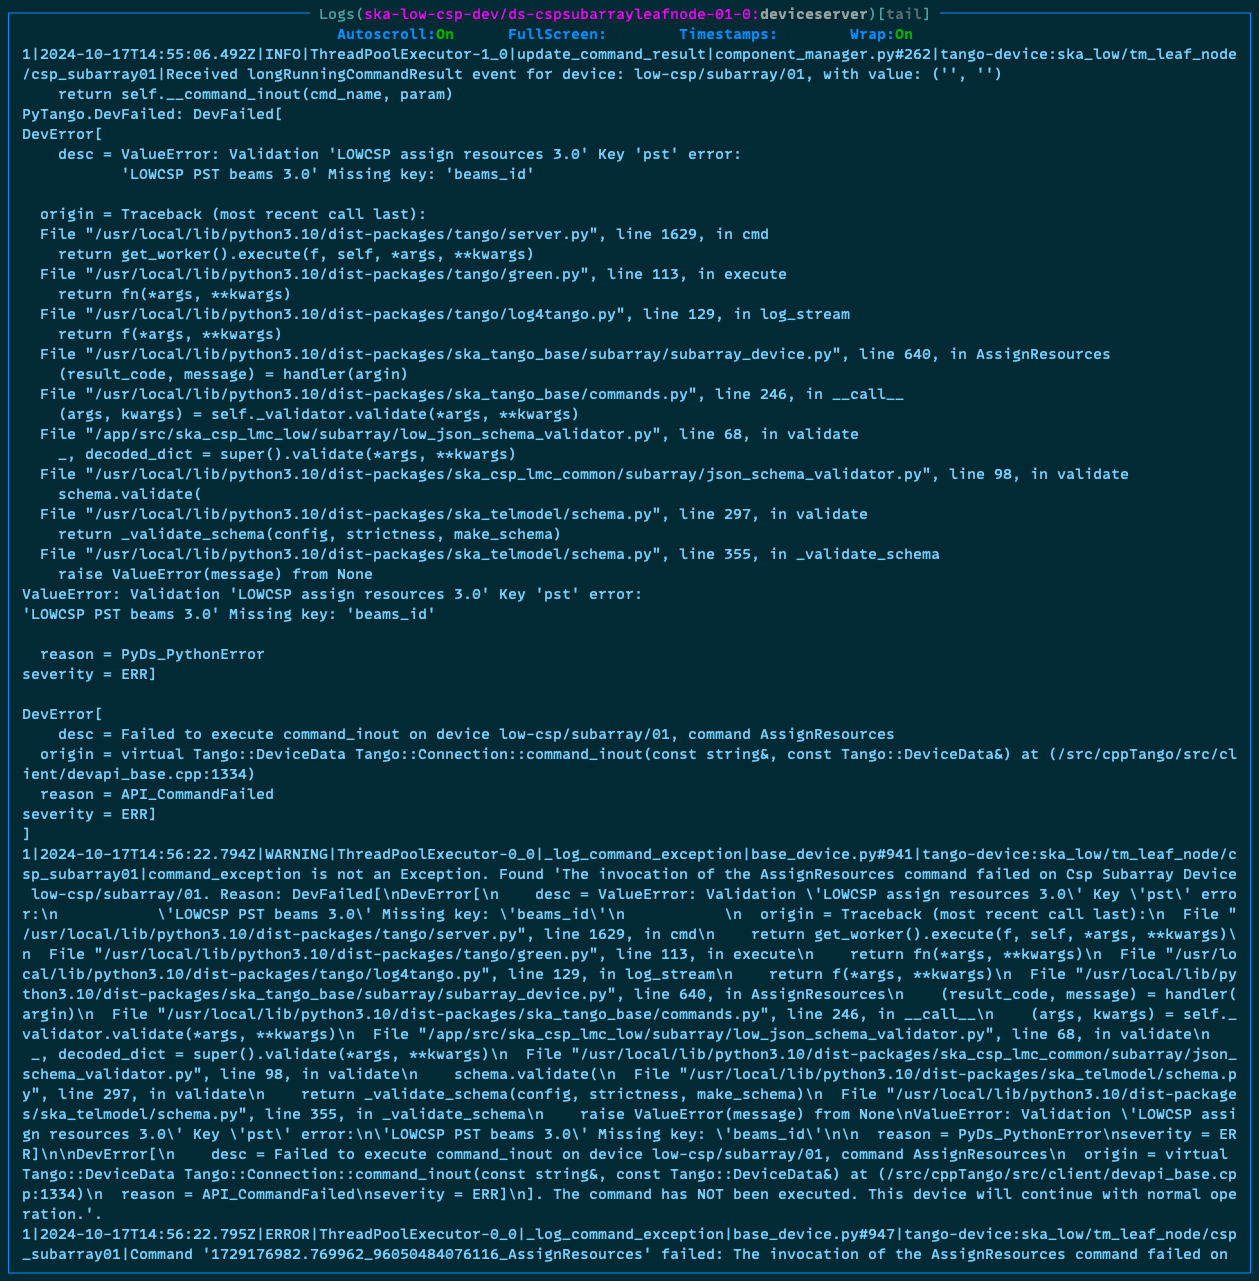

In [31]:
wait_obs_state( tmc_subarray, ObsState.IDLE, 10 )
print( '* AFTER AssignResources:' )
show_state()

* AFTER AssignResources:
  ska_low/tm_subarray_node/1   state: ON      , 1.adminMode.OFFLINE, 1.obsState.RESOURCING
  low-csp/subarray/01          state: ON      , 0.adminMode.ONLINE , 0.obsState.EMPTY     
  low-cbf/subarray/01          state: ON      , 0.adminMode.ONLINE , 0.obsState.EMPTY     
  ska_low/tm_leaf_node/csp_subarray01 state:       ON , 1.adminMode.OFFLINE


### Release Resources

In [32]:
release = {
    "interface": "https://schema.skao.int/ska-low-tmc-releaseresources/3.0",
    "subarray_id": 1,
    "release_all": True,
}
tmc_node.ReleaseResources(json.dumps(release))

[array([2], dtype=int32),
 ['1729177281.0515692_62756507518489_ReleaseResources']]